In [16]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath

import a_quantum_stateology_lib as qstates
import b_quantum_geometries_lib as gij
import c_matrix_analysis_lib as matAnsys 
import d_spin_representations_lib as su2
import e_maxent_solver_lib as me

from datetime import datetime
from qutip.qobj import Qobj
from collections.abc import Iterable
from typing import Callable, List, Optional, Tuple
from datetime import datetime

In [34]:
N=6; chain_type = "XX"; k_B = 1; temp = 1e0; temp_ref = 1e0

### One body local spin operators
spin_ops_list = su2.one_body_spin_ops(size = N)
identity_op = spin_ops_list[0][0]

### Heisenberg Hamiltonian
Hamiltonian_paras = [+1e-1, -2.5e-1, 0., .5e-1]
H_loc = su2.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                           size = N, Hamiltonian_paras = Hamiltonian_paras,
                                           closed_bcs = True, visualization = False)

### Generating classical observables

cl_ops, label_ops = su2.classical_ops(size = N, Hamiltonian = H_loc,
                                                op_list = spin_ops_list, centered_x_op = False)

## The Hamiltonian is added a perturbation term 
perturbation_strength = max(Hamiltonian_paras)/2 

HH = H_loc + perturbation_strength * cl_ops["x_op"]

In [35]:
def safe_expm_and_normalize(K) -> Qobj:
    n_eig = sum(K.dims[0])
    if n_eig <= 16:
        e0 = max(np.real(K.eigenenergies()))
    else:
        e0 = max(np.real(K.eigenenergies(sparse="True", sort="high", eigvals=n_eig)))
    sigma = (K - e0).expm()
    return qutip.Qobj(sigma / sigma.tr())

In [54]:
c1 = 0.1; c2 = 1; c3 = .5; zeta = .5; beta = 1/temp
K0_init = c1 * H_loc + c2 * (cl_ops["n_oc_op"] - zeta * identity_op)**2 + c3 * cl_ops["x_op"]

K0 = -(K0_init - max(K0_init.eigenenergies()))
rho0 = safe_expm_and_normalize(K0)

assert qstates.is_density_op(rho0), "rho0 is not density state"
qutip.expect(cl_ops["n_oc_op"], rho0)

1.2956651001099853

In [55]:
rho0.eigenenergies()

array([0.00000000e+00, 1.20823653e-10, 1.99322386e-10, 3.28627121e-10,
       5.41814527e-10, 8.93315095e-10, 1.49698425e-09, 1.30434212e-07,
       2.15049738e-07, 3.54557078e-07, 3.54766624e-07, 5.84574773e-07,
       5.84911282e-07, 9.64356023e-07, 9.64370481e-07, 9.79608993e-07,
       1.58997870e-06, 1.61605673e-06, 2.62143172e-06, 2.66442807e-06,
       4.39289926e-06, 7.24277766e-06, 3.14187778e-05, 5.18008075e-05,
       8.54051242e-05, 8.54064046e-05, 1.40811407e-04, 1.40892465e-04,
       1.43120925e-04, 2.32158763e-04, 2.32295971e-04, 2.35966598e-04,
       3.82991310e-04, 3.89043151e-04, 3.89273079e-04, 6.31446148e-04,
       6.41433569e-04, 6.41802808e-04, 1.05815433e-03, 1.05817019e-03,
       1.68867212e-03, 1.74462834e-03, 2.78419240e-03, 2.87640586e-03,
       4.59035726e-03, 4.66564765e-03, 7.56822240e-03, 7.69235256e-03,
       1.24852638e-02, 1.26825499e-02, 1.26827400e-02, 2.02519258e-02,
       2.09103109e-02, 2.09223478e-02, 3.39374355e-02, 3.44752744e-02,
      

In [56]:
subset_of_observables = {}; subset_label_ops = []
subset_of_observables["x_op"] = cl_ops["x_op"]; subset_label_ops.append("x_op")
subset_of_observables["n_oc_op"] = cl_ops["n_oc_op"]; subset_label_ops.append("n_oc_op")

In [57]:
ts = np.linspace(1e-1, 4., 500)
exact_ev = qutip.mesolve(H = HH,
                         rho0 = rho0,
                         tlist = ts,
                         e_ops = subset_of_observables
                         )

In [58]:
def fetch_kubo_scalar_product(sigma: Qobj, threshold=0.99999):
    evals_evecs = sorted(zip(*sigma.eigenstates()), key=lambda x: -x[0])
    w = 0
    for i, val_vec in enumerate(evals_evecs):
        w += val_vec[0]
        if w > threshold:
            evals_evecs = evals_evecs[: i + 1]
            break

    stored = {}
        
    def ksp(op1, op2):
        if False:
            key = (id(op2), id(op1))
            if key in stored:
                return stored[key]
            key = (id(op1), id(op2))
            if key in stored:
                return stored[key]

        result = sum(
        (
            np.conj((v2.dag() * op1 * v1).tr())
            * ((v2.dag() * op2 * v1).tr())
            * (p1 if p1 == p2 else (p1 - p2) / np.log(p1 / p2))
        )
        for p1, v1 in evals_evecs
        for p2, v2 in evals_evecs
        if (p1 > 0 and p2 > 0)
        )
        
        #    stored[key] = result
        return result

    return ksp

def fetch_kubo_int_scalar_product(sigma: Qobj):
    evals, evecs = sigma.eigenstates()

    def return_func(op1, op2):
        return 0.01 * sum(
            (
                np.conj((v2.dag() * op1 * v1).tr())
                * ((v2.dag() * op2 * v1).tr())
                * ((p1) ** (1.0 - tau))
                * ((p1) ** (tau))
            )
            for p1, v1 in zip(evals, evecs)
            for p2, v2 in zip(evals, evecs)
            for tau in np.linspace(0.0, 1.0, 100)
            if (p1 > 0.0 and p2 > 0.0)
        )

    return return_func

    return lambda op1, op2: 0.01 * sum(
        (
            np.conj((v2.dag() * op1 * v1).tr())
            * ((v2.dag() * op2 * v1).tr())
            * p1 ** (1 - tau)
            * p1 ** (tau)
        )
        for p1, v1 in zip(evals, evecs)
        for p2, v2 in zip(evals, evecs)
        for tau in np.linspace(0, 1, 100)
    )


def fetch_corr_scalar_product(sigma: Qobj):
    return lambda op1, op2: 0.5 * (sigma * (op1.dag() * op2 +
                                            op2 * op1.dag())).tr()

In [59]:
def gram_matrix(basis: list, sp: Callable):
    size = len(basis)
    result = np.zeros([size, size], dtype=float)

    for i, op1 in enumerate(basis):
        for j, op2 in enumerate(basis):
            if j < i:
                continue
            entry = np.real(sp(op1, op2))
            if i == j:
                result[i, i] = entry
            else:
                result[i, j] = result[j, i] = entry

    return result.round(14)


def orthogonalize_basis(basis: list, sp: Callable, idop: Qobj = None):
    if idop:
        idnorm_sq = sp(idop, idop)
        id_comp = [sp(idop, op) / idnorm_sq for op in basis]
        basis = ([idop * idnorm_sq**-0.5] +
                 [op - la for la, op in zip(id_comp, basis)])

    gs = gram_matrix(basis, sp)
    evals, evecs = np.linalg.eigh(gs)
    evecs = [vec / np.linalg.norm(vec) for vec in evecs.transpose()]
    return [
        p ** (-0.5) * sum(c * op for c, op in zip(w, basis))
        for p, w in zip(evals, evecs)
        if p > 0.00001
    ]


def project_op(op: Qobj, orthogonal_basis: list, sp: Callable):
    return np.array([sp(op2, op) for op2 in orthogonal_basis])

In [60]:
def logM(rho, svd = True):
    if isinstance(rho, qutip.Qobj):
        qutip_form = True
        dims = rho.dims
    else:
        qutip_form = False        

    if svd:            
        if qutip_form:
            rho = rho.full()
        U, Sigma, Vdag = linalg.svd(rho, full_matrices = False)
        matrix_log = U @ np.diag(np.log(Sigma)) @ U.conj().transpose() 
    else: 
        if qutip_form:
            eigvals, eigvecs = rho.eigenstates()
            matrix_log = sum([np.log(vl)*vc*vc.dag() for vl, vc in zip(eigvals, eigvecs)]) 
        else:
            rho = rho.full()
            eigvals, eigvecs = linalg.eigh(rho)
            return evecs @ np.array([np.log(ev)*np.array(f) for ev, f in zip(evals, evecs.transpose().conj())])
    
    if qutip_form:
        matrix_log = qutip.Qobj(matrix_log, dims)
    return matrix_log

def rel_entropy(rho, sigma, svd = True):
    if svd:
        val = (rho*(logM(rho, True) - logM(sigma, True))).tr()
    else:
        assert ((ev_checks(rho) and ev_checks(sigma))), "Either rho or sigma have negative ev."
        val = (rho*(logM(rho, False)-logM(sigma, False))).tr()
        if (abs(val.imag - 0)>1.e-10):
            val = None
            raise Exception("Either rho or sigma have negative ev.")
    return val.real

def fetch_induced_distance(sp):
    def distance(op1, op2):
        dop = op1 - op2
        return np.sqrt(sp(dop, dop))

    return distance

Para cada trayectoria, calcular la evolución de X y N
Entropías relativas entre los diferentes pares ((rho_KMB, rho_corr), (rho, rho_KMB) y (rho, rho_corr) )
Distancia KMB entre los diferentes pares ((K_KMB, K_corr), (K, K_KMB) y (K, K_corr) )

In [61]:
def instantaneous_projs_and_avgs(K_exact, rho_exact, basis, corr_sp, kmb_sp, subset_of_observables, subset_label_ops):
    "Hace de todo"
    # primero corr
    
    rel_entropies_at_timeti = {}; matrix_norms_at_timeti = {}; expected_values_at_timeti = {}
    distance = fetch_induced_distance(kmb_sp) #fixed
    
    basis = orthogonalize_basis(basis, corr_sp)
    kp_corr = sum(phi * op for phi, op in zip(project_op(K_exact, basis, corr_sp), basis))
    local_proj_state_corr = safe_expm_and_normalize(kp_corr)
    
    for name in subset_label_ops:
        expected_values_at_timeti["corr " + name] = qutip.expect(local_proj_state_corr, subset_of_observables[name]) # obs X y N para corr
    
    matrix_norms_at_timeti["kmb(exact_v_corr)"] = distance(kp_corr, K_exact) # (K, K_corr)
    
    # ahora kmb
    basis = orthogonalize_basis(basis, kmb_sp)
    kp_kmb = sum(phi * op for phi, op in zip(project_op(K_exact, basis, kmb_sp), basis))
    local_proj_state_kmb = safe_expm_and_normalize(kp_kmb)
    
    for name in subset_label_ops:
        expected_values_at_timeti["kmb " + name] = qutip.expect(local_proj_state_kmb, subset_of_observables[name]) # obs X y N para kmb
    
    matrix_norms_at_timeti["kmb(exact_v_kmb)"] = distance(K_exact, kp_kmb) #(K, K_KMB)
    matrix_norms_at_timeti["kmb(corr_v_kmb)"] = distance(kp_corr, kp_kmb) #(K_KMB, K_corr)
    
    kp_corr = kp_kmb = None
    
    rel_entropies_at_timeti["exact_v_kmb"] = rel_entropy(rho_exact, local_proj_state_kmb)
    rel_entropies_at_timeti["exact_v_corr"] = rel_entropy(rho_exact, local_proj_state_corr)
    rel_entropies_at_timeti["corr_v_kmb"] = rel_entropy(local_proj_state_corr, local_proj_state_kmb)
    rel_entropies_at_timeti["kmb_v_corr"] = rel_entropy(local_proj_state_kmb, local_proj_state_corr)
    
    local_proj_state_corr = local_proj_state_kmb = None
    
    return rel_entropies_at_timeti, matrix_norms_at_timeti, expected_values_at_timeti

In [62]:
def projections(Hamiltonian, K0, basis0, timespan, depth, beta, subset_of_observables, subset_label_ops):
    print("**** Starting Simulation", datetime.now())
    results = {}
    HBasis_local = matAnsys.build_Hierarchical_Basis(Hamiltonian = Hamiltonian,
                                                     seed_operator = HB_B0[-1], 
                                                     depth = depth,
                                                     tol = 1e-5, verbose = False)
    Hierarchical_B = []; del basis0[-1]
    Hierarchical_B = basis0  + HBasis_local
        
    for b in Hierarchical_B:
        b.__hash__ = lambda slf: hash(id(slf))
        
    res_exact, rhot = me.solve_exact(Hamiltonian = Hamiltonian,
                                     K0 = K0, 
                                     timespan = timespan,
                                     return_evolved_rhos = True,
                                     return_qutip_res_obj = True)
    K_at_timet = res_exact.states
    results["exact"] = K_at_timet
    results["exact_states"] = rhot
    ts = list(timespan)
    
    print("buildint the instantaneous KMB sp", datetime.now())
    inst_KMB_sp = [fetch_kubo_scalar_product(rho) for rho in rhot]
    print("buildint the instantaneous corr sp", datetime.now())
    inst_corr_sp = [fetch_corr_scalar_product(rho) for rho in rhot]
    
    print("corr", datetime.now())
    ts_list = list(timespan)
    results["projections"] = []
    for t in timespan: 
        ti = ts_list.index(t)
        if ti%5 == 0:
            print("------- Everything: step", ti, "at time", datetime.now())
        res_local = instantaneous_projs_and_avgs(K_at_timet[ti], 
                                                 rhot[ti], Hierarchical_B, 
                                                 inst_corr_sp[ti], inst_KMB_sp[ti], 
                                                 subset_of_observables, subset_label_ops)
        results["projections"].append(res_local)
        
    ts_list = None
    return results

In [63]:
ts = np.linspace(0, 5.,50)
HB_B0 = [identity_op, H_loc, cl_ops["n_oc_op"], cl_ops["n_oc_op"]**2,  cl_ops["x_op"]**2, cl_ops["x_op"], K0]
res = projections(Hamiltonian = HH, K0 = K0, basis0 = HB_B0, timespan = ts, depth = 4, beta = beta, 
                 subset_of_observables = subset_of_observables, subset_label_ops = subset_label_ops)

**** Starting Simulation 2023-06-19 15:31:41.279120
buildint the instantaneous KMB sp 2023-06-19 15:31:41.523964
buildint the instantaneous corr sp 2023-06-19 15:31:42.964484
corr 2023-06-19 15:31:42.964484
------- Everything: step 0 at time 2023-06-19 15:31:42.964484
------- Everything: step 5 at time 2023-06-19 15:35:31.947209
------- Everything: step 10 at time 2023-06-19 15:38:40.284835
------- Everything: step 15 at time 2023-06-19 15:41:45.374295
------- Everything: step 20 at time 2023-06-19 15:44:55.065917
------- Everything: step 25 at time 2023-06-19 15:48:01.291152
------- Everything: step 30 at time 2023-06-19 15:50:59.849947
------- Everything: step 35 at time 2023-06-19 15:53:57.108866
------- Everything: step 40 at time 2023-06-19 15:57:02.706658
------- Everything: step 45 at time 2023-06-19 16:00:11.700762


In [64]:
ts1 = list(ts)

states = res["exact_states"]
expected_values_exact_X = [(states[ts1.index(t)] * subset_of_observables["x_op"]).tr() for t in ts1]
expected_values_exact_N = [(states[ts1.index(t)] * subset_of_observables["n_oc_op"]).tr() for t in ts1]

relative_entropy_exact_v_kmb = [res["projections"][ts1.index(t)][0]["exact_v_kmb"] for t in ts1]
relative_entropy_exact_v_corr = [res["projections"][ts1.index(t)][0]["exact_v_corr"] for t in ts1]
relative_entropy_kmb_v_corr = [res["projections"][ts1.index(t)][0]["corr_v_kmb"] for t in ts1]
relative_entropy_corr_v_kmb = [res["projections"][ts1.index(t)][0]["kmb_v_corr"] for t in ts1]

kmb_exact_v_corr = [res["projections"][ts1.index(t)][1]["kmb(exact_v_corr)"] for t in ts1]
kmb_exact_v_kmb = [res["projections"][ts1.index(t)][1]["kmb(exact_v_kmb)"] for t in ts1]
kmb_corr_v_kmb = [res["projections"][ts1.index(t)][1]["kmb(corr_v_kmb)"] for t in ts1]
difference = [res["projections"][ts1.index(t)][1]["kmb(exact_v_corr)"] - res["projections"][ts1.index(t)][1]["kmb(corr_v_kmb)"] for t in ts1]

expected_values_corr_X = [res["projections"][ts1.index(t)][2]["corr x_op"] for t in ts1]
expected_values_corr_N = [res["projections"][ts1.index(t)][2]["corr n_oc_op"] for t in ts1]
expected_values_kmb_X = [res["projections"][ts1.index(t)][2]["kmb x_op"] for t in ts1]
expected_values_kmb_N = [res["projections"][ts1.index(t)][2]["kmb n_oc_op"] for t in ts1]

In [65]:
kmb_exact_v_corr_scaled = [res["projections"][ts1.index(t)][1]["kmb(exact_v_corr)"]/t**4 for t in ts1]
kmb_exact_v_kmb_scaled = [res["projections"][ts1.index(t)][1]["kmb(exact_v_kmb)"]/t**4 for t in ts1]
kmb_corr_v_kmb_scaled = [res["projections"][ts1.index(t)][1]["kmb(corr_v_kmb)"]/t**4 for t in ts1]

C:\Users\tomas\AppData\Local\Temp\ipykernel_15464\233697900.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  kmb_exact_v_corr_scaled = [res["projections"][ts1.index(t)][1]["kmb(exact_v_corr)"]/t**4 for t in ts1]
C:\Users\tomas\AppData\Local\Temp\ipykernel_15464\233697900.py:2: RuntimeWarning: invalid value encountered in double_scalars
  kmb_exact_v_kmb_scaled = [res["projections"][ts1.index(t)][1]["kmb(exact_v_kmb)"]/t**4 for t in ts1]
C:\Users\tomas\AppData\Local\Temp\ipykernel_15464\233697900.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  kmb_corr_v_kmb_scaled = [res["projections"][ts1.index(t)][1]["kmb(corr_v_kmb)"]/t**4 for t in ts1]


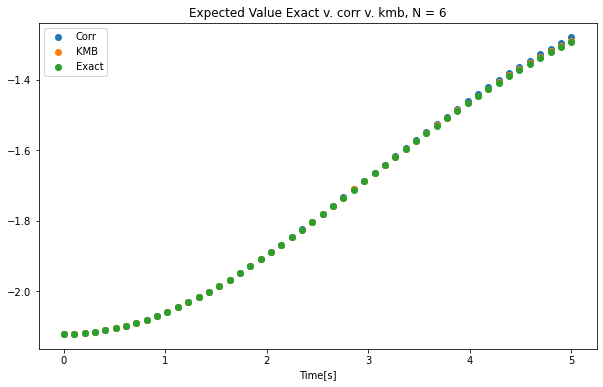

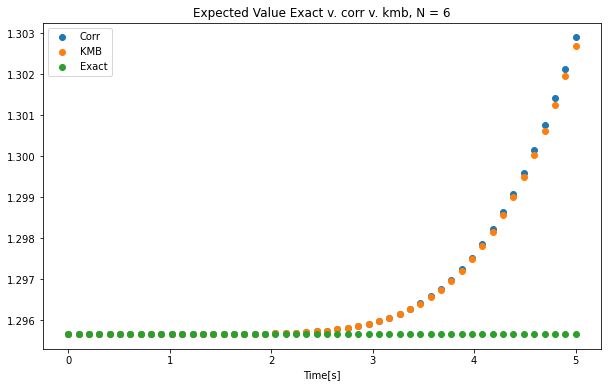

In [69]:
fig0, ax0 = plt.subplots(figsize=(10,6))

plt.title("Expected Value Exact v. corr v. kmb, N = 6")

plt.scatter(ts, expected_values_corr_X, label = "Corr")
plt.scatter(ts, expected_values_kmb_X, label = "KMB")
plt.scatter(ts, expected_values_exact_X, label = "Exact")

ax0.legend(loc = 0)
plt.xlabel("Time[s]")
plt.show()

fig1, ax1 = plt.subplots(figsize=(10,6))

plt.title("Expected Value Exact v. corr v. kmb, N = 6")

plt.scatter(ts, expected_values_corr_N, label = "Corr")
plt.scatter(ts, expected_values_kmb_N, label = "KMB")
plt.scatter(ts, expected_values_exact_N, label = "Exact")

ax1.legend(loc = 0)
plt.xlabel("Time[s]")
plt.show()

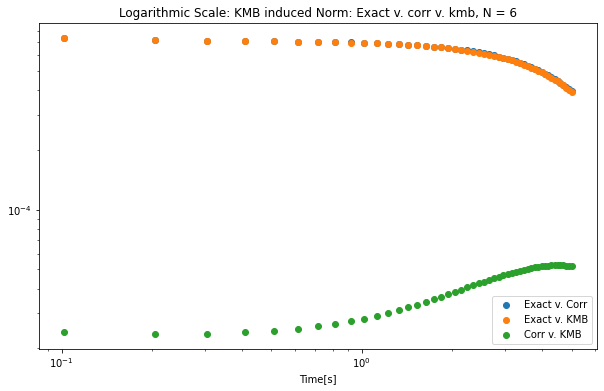

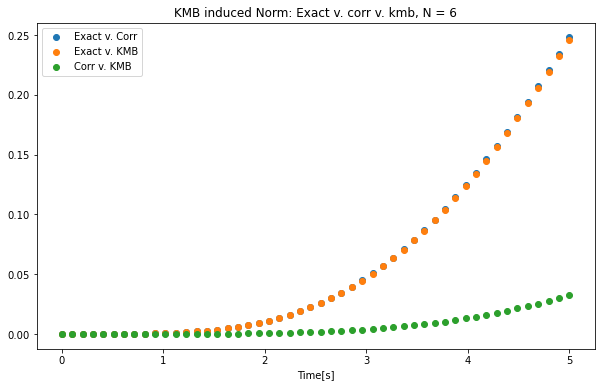

In [70]:
fig0, ax0 = plt.subplots(figsize=(10,6))

plt.title("Logarithmic Scale: KMB induced Norm: Exact v. corr v. kmb, N = 6")

plt.scatter(ts, kmb_exact_v_corr_scaled, label = "Exact v. Corr")
plt.scatter(ts, kmb_exact_v_kmb_scaled, label = "Exact v. KMB")
plt.scatter(ts, kmb_corr_v_kmb_scaled, label = "Corr v. KMB")

plt.xscale('log')
plt.yscale('log')
ax0.legend(loc = 0)
plt.xlabel("Time[s]")
plt.show()

fig1, ax1 = plt.subplots(figsize=(10,6))

plt.title("KMB induced Norm: Exact v. corr v. kmb, N = 6")

plt.scatter(ts, kmb_exact_v_corr, label = "Exact v. Corr")
plt.scatter(ts, kmb_exact_v_kmb, label = "Exact v. KMB")
plt.scatter(ts, kmb_corr_v_kmb, label = "Corr v. KMB")

ax1.legend(loc = 0)
plt.xlabel("Time[s]")
plt.show()

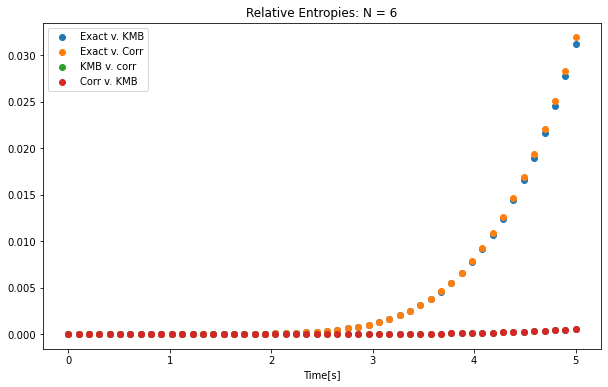

In [71]:
fig0, ax0 = plt.subplots(figsize=(10,6))

plt.title("Relative Entropies: N = 6")

plt.scatter(ts, relative_entropy_exact_v_kmb, label = "Exact v. KMB")
plt.scatter(ts, relative_entropy_exact_v_corr, label = "Exact v. Corr")
plt.scatter(ts, relative_entropy_kmb_v_corr, label = "KMB v. corr")
plt.scatter(ts, relative_entropy_corr_v_kmb, label = "Corr v. KMB")

ax0.legend(loc = 0)
plt.xlabel("Time[s]")
plt.show()